### Playing Gridworld using Actor/Critic

#### Introduction

This tutorial builds off of [Outlace's excelent blog entry on Q-Learning](http://outlace.com/Reinforcement-Learning-Part-3/) and this is the [starting point](https://www2.informatik.uni-hamburg.de/~weber/code/ActorCritic.py) for my Actor Critic implementation.

I got interested in Actor-Critic reinforcement learning after skimming DeepMind's follow-up to their original Atari paper. The new paper [Asynchronous Methods for Deep Reinforcement Learning](http://arxiv.org/abs/1602.01783) uses an Actor/Critic learning implementation to surpass the performance of their original Deep Q-Network. I couldn't find a good straightforward implementation/example of it.

For a slightly more in-depth explination check out [Actor-Critic Methods](https://webdocs.cs.ualberta.ca/~sutton/book/ebook/node66.html) from the book 'Reinforcement Learning: An Introduction' by Sutton and Barto


# Our Gridworld

This is the gridworld implementation from [the original Q-learning tutorial](http://outlace.com/Reinforcement-Learning-Part-3/) which we will use as the environment for our Actor/Critic learner. One small tweak I made is to end the episode if the Agent has made more than 40 moves but still hasn't made it to a terminal state.

In [1]:
%pylab inline

import numpy as np

# This is added - implicitly limit move count.
MAX_MOVES=40
move_counter = 0

def randPair(s,e):
    return np.random.randint(s,e), np.random.randint(s,e)

#finds an array in the "depth" dimension of the grid
def findLoc(state, obj):
    for i in range(0,4):
        for j in range(0,4):
            if (state[i,j] == obj).all():
                return i,j

#Initialize stationary grid, all items are placed deterministically
def initGrid():
    global move_counter
    move_counter = 0
    state = np.zeros((4,4,4))
    #place player
    state[0,1] = np.array([0,0,0,1])
    #place wall
    state[2,2] = np.array([0,0,1,0])
    #place pit
    state[1,1] = np.array([0,1,0,0])
    #place goal
    state[3,3] = np.array([1,0,0,0])
    
    return state

#Initialize player in random location, but keep wall, goal and pit stationary
def initGridPlayer():
    global move_counter
    move_counter = 0
    state = np.zeros((4,4,4))
    #place player
    state[randPair(0,4)] = np.array([0,0,0,1])
    #place wall
    state[2,2] = np.array([0,0,1,0])
    #place pit
    state[1,1] = np.array([0,1,0,0])
    #place goal
    state[1,2] = np.array([1,0,0,0])
    
    a = findLoc(state, np.array([0,0,0,1])) #find grid position of player (agent)
    w = findLoc(state, np.array([0,0,1,0])) #find wall
    g = findLoc(state, np.array([1,0,0,0])) #find goal
    p = findLoc(state, np.array([0,1,0,0])) #find pit
    if (not a or not w or not g or not p):
        #print('Invalid grid. Rebuilding..')
        return initGridPlayer()
    
    return state

#Initialize grid so that goal, pit, wall, player are all randomly placed
def initGridRand():
    global move_counter
    move_counter = 0
    state = np.zeros((4,4,4))
    #place player
    state[randPair(0,4)] = np.array([0,0,0,1])
    #place wall
    state[randPair(0,4)] = np.array([0,0,1,0])
    #place pit
    state[randPair(0,4)] = np.array([0,1,0,0])
    #place goal
    state[randPair(0,4)] = np.array([1,0,0,0])
    
    a = findLoc(state, np.array([0,0,0,1]))
    w = findLoc(state, np.array([0,0,1,0]))
    g = findLoc(state, np.array([1,0,0,0]))
    p = findLoc(state, np.array([0,1,0,0]))
    #If any of the "objects" are superimposed, just call the function again to re-place
    if (not a or not w or not g or not p):
        #print('Invalid grid. Rebuilding..')
        return initGridRand()
    
    return state

def makeMove(state, action):
    #need to locate player in grid
    #need to determine what object (if any) is in the new grid spot the player is moving to
    player_loc = findLoc(state, np.array([0,0,0,1]))
    wall = findLoc(state, np.array([0,0,1,0]))
    goal = findLoc(state, np.array([1,0,0,0]))
    pit = findLoc(state, np.array([0,1,0,0]))
    state = np.zeros((4,4,4))
    
    #up (row - 1)
    if action==0:
        new_loc = (player_loc[0] - 1, player_loc[1])
        if (new_loc != wall):
            if ((np.array(new_loc) <= (3,3)).all() and (np.array(new_loc) >= (0,0)).all()):
                state[new_loc][3] = 1
    #down (row + 1)
    elif action==1:
        new_loc = (player_loc[0] + 1, player_loc[1])
        if (new_loc != wall):
            if ((np.array(new_loc) <= (3,3)).all() and (np.array(new_loc) >= (0,0)).all()):
                state[new_loc][3] = 1
    #left (column - 1)
    elif action==2:
        new_loc = (player_loc[0], player_loc[1] - 1)
        if (new_loc != wall):
            if ((np.array(new_loc) <= (3,3)).all() and (np.array(new_loc) >= (0,0)).all()):
                state[new_loc][3] = 1
    #right (column + 1)
    elif action==3:
        new_loc = (player_loc[0], player_loc[1] + 1)
        if (new_loc != wall):
            if ((np.array(new_loc) <= (3,3)).all() and (np.array(new_loc) >= (0,0)).all()):
                state[new_loc][3] = 1
                
    new_player_loc = findLoc(state, np.array([0,0,0,1]))
    if (not new_player_loc):
        state[player_loc] = np.array([0,0,0,1])
    #re-place pit
    state[pit][1] = 1
    #re-place wall
    state[wall][2] = 1
    #re-place goal
    state[goal][0] = 1
    global move_counter
    move_counter += 1
    
    return state

def getLoc(state, level):
    for i in range(0,4):
        for j in range(0,4):
            if (state[i,j][level] == 1):
                return i,j

def getReward(state):
    player_loc = getLoc(state, 3)
    pit = getLoc(state, 1)
    goal = getLoc(state, 0)
    if (player_loc == pit):
        return -10
    elif (player_loc == goal):
        return 10
    elif (move_counter > MAX_MOVES):
        return -9
    else:
        return -1
    
def dispGrid(state):
    grid = np.zeros((4,4), dtype='<U2')
    player_loc = findLoc(state, np.array([0,0,0,1]))
    wall = findLoc(state, np.array([0,0,1,0]))
    goal = findLoc(state, np.array([1,0,0,0]))
    pit = findLoc(state, np.array([0,1,0,0]))
    for i in range(0,4):
        for j in range(0,4):
            grid[i,j] = ' '
            
    if player_loc:
        grid[player_loc] = 'P' #player
    if wall:
        grid[wall] = 'W' #wall
    if goal:
        grid[goal] = '+' #goal
    if pit:
        grid[pit] = '-' #pit
    
    return grid


Populating the interactive namespace from numpy and matplotlib


Lets make sure our original implementation is working before we continue...

In [2]:
state = initGrid()
dispGrid(state)

array([[u' ', u'P', u' ', u' '],
       [u' ', u'-', u' ', u' '],
       [u' ', u' ', u'W', u' '],
       [u' ', u' ', u' ', u'+']], 
      dtype='<U2')

And move our player into the winning position.

In [3]:
LEFT=2
RIGHT=3
UP=0
DOWN=1
A2S=['up','down','left','right']
state = initGrid()
state = makeMove(state, RIGHT)
state = makeMove(state, RIGHT)
state = makeMove(state, DOWN)
state = makeMove(state, DOWN)
state = makeMove(state, DOWN)
print('Reward: %s' % (getReward(state),))
dispGrid(state)


Reward: 10


array([[u' ', u' ', u' ', u' '],
       [u' ', u'-', u' ', u' '],
       [u' ', u' ', u'W', u' '],
       [u' ', u' ', u' ', u' ']], 
      dtype='<U2')

# The Actor

In Actor/Critic there are two networks. The 'policy' network (the Actor) and the 'value' network (the Critic). You will recognize the policy network as being essentially the same as the network from the Q-Learning example.

In [4]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [5]:
actor_model = Sequential()
actor_model.add(Dense(164, init='lecun_uniform', input_shape=(64,)))
actor_model.add(Activation('relu'))

actor_model.add(Dense(150, init='lecun_uniform'))
actor_model.add(Activation('relu'))

actor_model.add(Dense(4, init='lecun_uniform'))
actor_model.add(Activation('linear'))

rms = RMSprop()
actor_model.compile(loss='mse', optimizer=rms)


Next, we set up the Critic network. This network looks very similar to the Actor model, but only outputs a single value - it outputs a value (the score) for the input state.

In [6]:
critic_model = Sequential()

critic_model.add(Dense(256, init='lecun_uniform', input_shape=(64,)))
critic_model.add(Activation('relu'))

critic_model.add(Dense(128, init='lecun_uniform'))
critic_model.add(Activation('relu'))

critic_model.add(Dense(64, init='lecun_uniform'))
critic_model.add(Activation('relu'))

critic_model.add(Dense(1, init='lecun_uniform', activation='linear' ))

rms = RMSprop()
critic_model.compile(loss='mse', optimizer=rms)


The 'test' stays essentially the same. It is important to note, that when testing, we only need the actor/policy network. The critic network is not involved. The Actor has learned the correct policy/moves as it trains on the values supplied by the critic network.

In [7]:
def testAlgo( initial_state=initGrid() ):
    state = initial_state.copy()

    print("Initial State:")
    print(dispGrid(state))
    i = 0
    status = 1
    #while game still in progress
    while(status == 1):
        qval = actor_model.predict(state.reshape(1,64), batch_size=1)
        action = (np.argmax(qval)) #take action with highest Q-value
        print('Move #: %s; Taking action: %s' % (i, A2S[action]))
        state = makeMove(state, action)
        print(dispGrid(state))
        reward = getReward(state)
        if reward != -1:
            status = 0
            print("Reward: %s" % (reward,))
        i += 1 #If we're taking more than 10 actions, just stop, we probably can't win this game
        if (i > 10):
            print("Game lost; too many moves.")
            break

# The Trainer

The trainer is implemented below. Items of note.
* __early stopping__ the trainer implements early-stopping. If the game is winning a given percentage of the time (99% is the default) then the trainer will stop early. No point training any further.
* __experience replay__ essentially the same as the example in the Q-learning tutorial. However we replay both the Actor and the Critic's experiences

The big main new things here are the split of the Critic network, and state values, from the Actor, and action selection.

To train the critic network, we use a simlar process to training value into Q networks. We look at the initial state, make a move, and then look at the new state. For the value network, if we are in a terminal state, that's the value we tell the value network to place on that state. If we are in a non-terminal state, we tell the value network to place a value on the original state which is the reward in the original state, plus the discounted value from the new state. Note that the value network should return the maximum possible value for a given state. If the player's next move could be either jumping into the pit or arriving at the goal, we should set the value as if the best-possible action will be selected.

After the critic network has assigned a value to the original and the new state, we adjust the policy. This is simply by looking at our value in our old state, and the value in the new state. If the value improves we encourage that action. If it decreases we discourage the action.

When we start training, both the actor and the critic networks are spitting out nonsensical values. Which means initially the actor network is training on values from the critic network which are garbage. However as the critic network improves, those improvements naturally correct and improve the performance of the actor network.



In [8]:
from IPython.display import clear_output
import random
import time

def trainer(game_type='easy',epochs=1000, batchSize=40, 
            gamma=0.9, epsilon=1, min_epsilon=0.1,
            buffer=80,earlystop=0.99):
    
    status = 1
    
    # Early-stopping.
    earlystop_acc = 0.0
    earlystop_decay = 0.9
        
    # Replay buffers
    actor_replay = []
    critic_replay = []
    
    for i in range(epochs):
        if game_type == 'hard':
            state = initGridRand()
        elif game_type == 'medium':
            state = initGridPlayer()
        else:
            state = initGrid() # easy

        status = 1
        #while game still in progress
        while(status == 1):
            # Get original state, original reward, and critic's value for this state.
            orig_state = np.copy(state)
            orig_reward = getReward(orig_state)
            orig_val = critic_model.predict(orig_state.reshape(1,64))

            if (random.random() < epsilon): #choose random action
                action = np.random.randint(0,4)
            else: #choose best action from Q(s,a) values
                qval = actor_model.predict( orig_state.reshape(1,64) )
                action = (np.argmax(qval))
                
            #Take action, observe new state S'
            new_state = makeMove(state, action)
            #Observe reward
            new_reward = getReward(new_state)
            
            # Critic's value for this new state.
            new_val = critic_model.predict(new_state.reshape(1,64))
            
            if new_reward == -1: # Non-terminal state.
                target = orig_reward + ( gamma * new_val)
            else:
                # In terminal states, the environment tells us
                # the value directly.
                target = orig_reward + ( gamma * new_reward )
            
            # For our critic, we select the best/highest value.. The
            # value for this state is based on if the agent selected
            # the best possible moves from this state forward.
            # 
            # BTW, we discount an original value provided by the
            # value network, to handle cases where its spitting
            # out unreasonably high values.. naturally decaying
            # these values to something reasonable.
            best_val = max((orig_val*gamma), target)

            # Now append this to our critic replay buffer.
            critic_replay.append([orig_state,best_val])
            # If we are in a terminal state, append a replay for it also.
            if new_reward != -1:
                critic_replay.append( [new_state, float(new_reward)] )
            
            # Build the update for the Actor. The actor is updated
            # by using the difference of the value the critic
            # placed on the old state vs. the value the critic
            # places on the new state.. encouraging the actor
            # to move into more valuable states.
            actor_delta = new_val - orig_val                
            actor_replay.append([orig_state, action, actor_delta])
                    
            # Critic Replays...
            while(len(critic_replay) > buffer): # Trim replay buffer
                critic_replay.pop(0)
            # Start training when we have enough samples.
            if(len(critic_replay) >= buffer):
                minibatch = random.sample(critic_replay, batchSize)
                X_train = []
                y_train = []
                for memory in minibatch:
                    m_state, m_value = memory
                    y = np.empty([1])
                    y[0] = m_value
                    X_train.append(m_state.reshape((64,)))
                    y_train.append(y.reshape((1,)))
                X_train = np.array(X_train)
                y_train = np.array(y_train)
                critic_model.fit(X_train, y_train, batch_size=batchSize, nb_epoch=1, verbose=0)
            
            # Actor Replays...
            while(len(actor_replay) > buffer):
                actor_replay.pop(0)                
            if(len(actor_replay) >= buffer):
                X_train = []
                y_train = []
                minibatch = random.sample(actor_replay, batchSize)
                for memory in minibatch:
                    m_orig_state, m_action, m_value = memory
                    old_qval = actor_model.predict( m_orig_state.reshape(1,64,) )
                    y = np.zeros(( 1, 4 ))
                    y[:] = old_qval[:]
                    # non-standard - decay actions we aren't selecting on this turn.
                    #y[:] = old_qval[:] * gamma
                    y[0][m_action] = m_value
                    X_train.append(m_orig_state.reshape((64,)))
                    y_train.append(y.reshape((4,)))
                X_train = np.array(X_train)
                y_train = np.array(y_train)
                actor_model.fit(X_train, y_train, batch_size=batchSize, nb_epoch=1, verbose=0)

            # Finished replays.
                
            state = new_state
            if new_reward != -1:
                status = 0
                # Count wins/losses for early-stopping.
                if new_reward == 10: # Win
                    earlystop_result = 1.0
                else: # Loss
                    earlystop_result = 0.0
                new_acc = ( earlystop_acc * earlystop_decay ) + \
                    ((1.0 - earlystop_decay ) * earlystop_result)
                earlystop_acc = new_acc

        # Finised Epoch
        clear_output(wait=True)
        print("Game #: %s" % (i,))
        print("Accumulated win percent: %.2f%%" % (earlystop_acc*100) )

        if epsilon > min_epsilon:
            epsilon -= (1/epochs)
        # Check if we can early-stop training.
        if earlystop_acc > earlystop:
            print("Early-Stopping Training")
            break
            

In [9]:
trainer()

Game #: 999
Accumulated win percent: 11.48%


For me, the training early-stops after acheving better than a 99% score. Well before 1000 epochs are complete. Lets see how we did by testing the model.

In [10]:
testAlgo()

Initial State:
[[u' ' u'P' u' ' u' ']
 [u' ' u'-' u' ' u' ']
 [u' ' u' ' u'W' u' ']
 [u' ' u' ' u' ' u'+']]
Move #: 0; Taking action: right
[[u' ' u' ' u'P' u' ']
 [u' ' u'-' u' ' u' ']
 [u' ' u' ' u'W' u' ']
 [u' ' u' ' u' ' u'+']]
Move #: 1; Taking action: down
[[u' ' u' ' u' ' u' ']
 [u' ' u'-' u'P' u' ']
 [u' ' u' ' u'W' u' ']
 [u' ' u' ' u' ' u'+']]
Move #: 2; Taking action: right
[[u' ' u' ' u' ' u' ']
 [u' ' u'-' u' ' u'P']
 [u' ' u' ' u'W' u' ']
 [u' ' u' ' u' ' u'+']]
Move #: 3; Taking action: down
[[u' ' u' ' u' ' u' ']
 [u' ' u'-' u' ' u' ']
 [u' ' u' ' u'W' u'P']
 [u' ' u' ' u' ' u'+']]
Move #: 4; Taking action: down
[[u' ' u' ' u' ' u' ']
 [u' ' u'-' u' ' u' ']
 [u' ' u' ' u'W' u' ']
 [u' ' u' ' u' ' u' ']]
Reward: 10


Now we can examine what the value network has learned - and the values it has placed on any given location on the board.

Board State:
[[u' ' u'P' u' ' u' ']
 [u' ' u'-' u' ' u' ']
 [u' ' u' ' u'W' u' ']
 [u' ' u' ' u' ' u'+']]


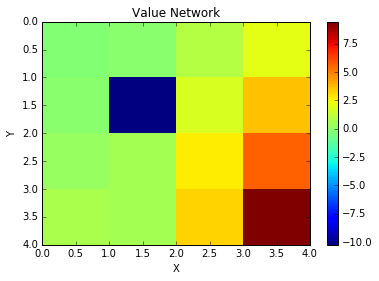

In [11]:
def plot_value(initial_state):
    np_w_cri_r = np.zeros((4,4))
    # Remove player from initial state.
    working_state = initial_state.copy()
    p = findLoc(working_state, np.array([0,0,0,1]))
    working_state[p[0],p[1]] = np.array([0,0,0,0])
    for x in range(0,4):
        for y in range(0,4):
            my_state = working_state.copy()
            # Place the player at a given X/Y location.
            my_state[x,y,3] = 1
            # And now have the critic model predict the state value
            # with the player in that location.
            value = critic_model.predict(my_state.reshape(1, 64))
            #print("x,y: %s, %s - value %f" % (x, y, value) )
            np_w_cri_r[x,y] = value
    np_w_cri_r.shape
    pylab.pcolor(np_w_cri_r)
    pylab.title("Value Network")
    pylab.colorbar()
    pylab.xlabel("X")
    pylab.ylabel("Y")
    pylab.gca().invert_yaxis()
    pylab.draw()

easy_state = initGrid()
print("Board State:")
print(dispGrid(easy_state))
plot_value(easy_state)


We can see that the value network has placed a high value on the winning final position. That value equaling the reward gained when in that position. It also places a very low value on the 'pit' position. Makes sense. Then we can see that the network places ever growing value on positions which move us closer to the winning position. Thus the value network can express to the policy network that a move which moves us closer to the winning position is more valuable. Lets take a look at what the policy network has learned.

In [12]:
A2A=['^','v','<','>']
def show_policy(initial_state):
    grid = np.zeros((4,4), dtype='<U2')
    working_state = initial_state.copy()
    p = findLoc(working_state, np.array([0,0,0,1]))
    working_state[p[0],p[1]] = np.array([0,0,0,0])
    for x in range(0,4):
        for y in range(0,4):
            #for a in range(0, 4):
            my_state = working_state.copy()
            my_state[x,y,3] = 1
            #
            qval = actor_model.predict(my_state.reshape(1, 64))
            action = (np.argmax(qval))
            grid[x,y] = A2A[action]
    return grid

easy_state = initGrid()
print("Board State")
print(dispGrid(easy_state))
print("Action Policy")
print(show_policy(easy_state))


Board State
[[u' ' u'P' u' ' u' ']
 [u' ' u'-' u' ' u' ']
 [u' ' u' ' u'W' u' ']
 [u' ' u' ' u' ' u'+']]
Action Policy
[[u'>' u'>' u'v' u'v']
 [u'v' u'v' u'>' u'v']
 [u'>' u'v' u'>' u'v']
 [u'>' u'>' u'>' u'v']]


Lets just dive into training on the hard variant.

In [13]:
trainer(game_type='hard',epochs=5000,earlystop=0.999,min_epsilon=0.01)

Game #: 4999
Accumulated win percent: 22.98%


In [14]:
hard_state = initGridRand()
testAlgo(hard_state)



Initial State:
[[u' ' u' ' u' ' u'+']
 [u' ' u' ' u'W' u'P']
 [u' ' u' ' u' ' u' ']
 [u' ' u' ' u'-' u' ']]
Move #: 0; Taking action: up
[[u' ' u' ' u' ' u' ']
 [u' ' u' ' u'W' u' ']
 [u' ' u' ' u' ' u' ']
 [u' ' u' ' u'-' u' ']]
Reward: 10


Now lets take a quick look at what our agent learned to solve this grid.

Board State:
[[u' ' u' ' u' ' u'+']
 [u' ' u' ' u'W' u'P']
 [u' ' u' ' u' ' u' ']
 [u' ' u' ' u'-' u' ']]
Policy
[[u'>' u'>' u'>' u'v']
 [u'v' u'>' u'>' u'^']
 [u'>' u'^' u'<' u'>']
 [u'v' u'<' u'v' u'^']]


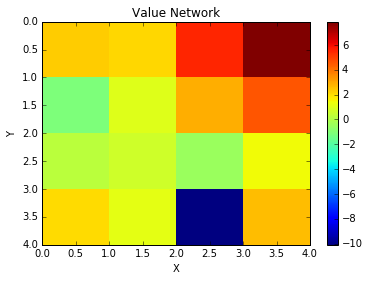

In [15]:
print("Board State:")
print(dispGrid(hard_state))
plot_value(hard_state)
print("Policy")
print(show_policy(hard_state))


The agent can solve many random configurations of gridworld.. But there's some configurations which give it trouble. It seems to have a hard time with walls. Here's an example problematic grid configuration.

In [16]:
def initGridEvil():
    global move_counter
    move_counter = 0
    state = np.zeros((4,4,4))
    #place player
    state[2,1] = np.array([0,0,0,1])
    #place wall
    state[3,1] = np.array([0,0,1,0])
    #place pit
    state[2,2] = np.array([0,1,0,0])
    #place goal
    state[3,2] = np.array([1,0,0,0])
    return state

grid_evil = initGridEvil()
#print(dispGrid(grid_evil))
testAlgo(grid_evil)

Initial State:
[[u' ' u' ' u' ' u' ']
 [u' ' u' ' u' ' u' ']
 [u' ' u'P' u'-' u' ']
 [u' ' u'W' u'+' u' ']]
Move #: 0; Taking action: left
[[u' ' u' ' u' ' u' ']
 [u' ' u' ' u' ' u' ']
 [u'P' u' ' u'-' u' ']
 [u' ' u'W' u'+' u' ']]
Move #: 1; Taking action: right
[[u' ' u' ' u' ' u' ']
 [u' ' u' ' u' ' u' ']
 [u' ' u'P' u'-' u' ']
 [u' ' u'W' u'+' u' ']]
Move #: 2; Taking action: left
[[u' ' u' ' u' ' u' ']
 [u' ' u' ' u' ' u' ']
 [u'P' u' ' u'-' u' ']
 [u' ' u'W' u'+' u' ']]
Move #: 3; Taking action: right
[[u' ' u' ' u' ' u' ']
 [u' ' u' ' u' ' u' ']
 [u' ' u'P' u'-' u' ']
 [u' ' u'W' u'+' u' ']]
Move #: 4; Taking action: left
[[u' ' u' ' u' ' u' ']
 [u' ' u' ' u' ' u' ']
 [u'P' u' ' u'-' u' ']
 [u' ' u'W' u'+' u' ']]
Move #: 5; Taking action: right
[[u' ' u' ' u' ' u' ']
 [u' ' u' ' u' ' u' ']
 [u' ' u'P' u'-' u' ']
 [u' ' u'W' u'+' u' ']]
Move #: 6; Taking action: left
[[u' ' u' ' u' ' u' ']
 [u' ' u' ' u' ' u' ']
 [u'P' u' ' u'-' u' ']
 [u' ' u'W' u'+' u' ']]
Move #: 7; Taking act

Board State:
[[u' ' u'P' u' ' u' ']
 [u' ' u'-' u' ' u' ']
 [u' ' u' ' u'W' u' ']
 [u' ' u' ' u' ' u'+']]
Policy
[[u'>' u'>' u'>' u'v']
 [u'v' u'>' u'>' u'^']
 [u'>' u'^' u'<' u'>']
 [u'v' u'<' u'v' u'^']]
Initial State:
[[u' ' u'P' u' ' u' ']
 [u' ' u'-' u' ' u' ']
 [u' ' u' ' u'W' u' ']
 [u' ' u' ' u' ' u'+']]
Move #: 0; Taking action: right
[[u' ' u' ' u'P' u' ']
 [u' ' u'-' u' ' u' ']
 [u' ' u' ' u'W' u' ']
 [u' ' u' ' u' ' u'+']]
Move #: 1; Taking action: up
[[u' ' u' ' u'P' u' ']
 [u' ' u'-' u' ' u' ']
 [u' ' u' ' u'W' u' ']
 [u' ' u' ' u' ' u'+']]
Move #: 2; Taking action: up
[[u' ' u' ' u'P' u' ']
 [u' ' u'-' u' ' u' ']
 [u' ' u' ' u'W' u' ']
 [u' ' u' ' u' ' u'+']]
Move #: 3; Taking action: up
[[u' ' u' ' u'P' u' ']
 [u' ' u'-' u' ' u' ']
 [u' ' u' ' u'W' u' ']
 [u' ' u' ' u' ' u'+']]
Move #: 4; Taking action: up
[[u' ' u' ' u'P' u' ']
 [u' ' u'-' u' ' u' ']
 [u' ' u' ' u'W' u' ']
 [u' ' u' ' u' ' u'+']]
Move #: 5; Taking action: up
[[u' ' u' ' u'P' u' ']
 [u' ' u'-' u' ' u' '

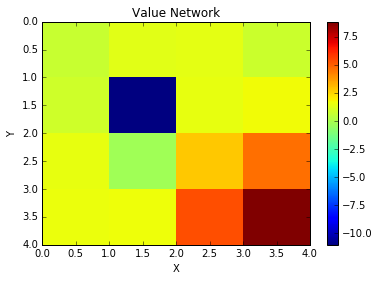

In [17]:
easy_state = initGrid()
print("Board State:")
print(dispGrid(easy_state))
plot_value(easy_state)
print("Policy")
print(show_policy(hard_state))
testAlgo(easy_state)